In [1]:
%load_ext autoreload
%autoreload 2

from binance.client import Client
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime
from libs import *
from utils import *

with open("C:\\Users\\thang\\OneDrive\\Documents\\binance_cres\\api_key.txt") as api_file:
    api_key = api_file.readline()
with open("C:\\Users\\thang\\OneDrive\\Documents\\binance_cres\\sec_key.txt") as api_file:
    api_secret = api_file.readline()
# make binance object
client = Client(api_key, api_secret)

# Parameters
target_coin = 'ETCUSDT'
BATCH_SIZE = 32


In [2]:
avg_data = client.get_klines(symbol=target_coin, interval=Client.KLINE_INTERVAL_30MINUTE)
cols = ['open_time',  # Open time
            'open',  # Open
            'high',  # High
            'low',  # Low
            'close',  # Close
            'vol',  # Volume
            'close_time',  # Close time
            'quote_ass_vol',  # Quote asset volume
            'no_trade',  # Number of trades
            'base_ass_vol',  # Taker buy base asset volume
            'qoute_ass_vol',  # Taker buy quote asset volume
            'ignore']   # Can be ignored
df = pd.DataFrame(avg_data, 
    columns = cols)

important_features_df = df[['close','close_time','vol']]  # get important features
important_features_df.close_time = important_features_df.close_time.apply(lambda x: x/1000)  # convert milisecond to second
important_features_df = data_converter(important_features_df)  # conver time data to sequence vector

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\Users\thang\Documents\pred_coin_price\ts_pred_viz\utils.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(date_time * (2 * np.pi / day))
c:\Users\thang\Documents\pred_coin_price\ts_pred_viz\utils.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [3]:
important_features_df.describe()

,close,vol,Day sin,Day cos,Year sin,Year cos
count,500.000000,500.000000,5.000000e+02,5.000000e+02,500.000000,500.000000
mean,66.366516,61933.896646,2.220755e-02,-1.947549e-02,0.487191,-0.871763
std,2.550755,53221.262041,7.078198e-01,7.071923e-01,0.045169,0.025262
min,60.678000,7836.885000,-1.000000e+00,-1.000000e+00,0.407942,-0.913008
25%,64.101750,27571.309750,-7.071067e-01,-7.071068e-01,0.448341,-0.893863
50%,66.531000,47694.745500,7.272505e-08,-7.272298e-08,0.487844,-0.872931
75%,68.344750,77130.966500,7.071068e-01,7.071067e-01,0.526371,-0.850255
max,77.847000,466494.895000,1.000000e+00,1.000000e+00,0.563847,-0.825879


In [4]:
# data splitting
# column_indices = {name: i for i, name in enumerate(important_features_df.columns)}

n = len(important_features_df)
train_df = important_features_df[0:int(n*0.7)]  # 70% train data
val_df = important_features_df[int(n*0.7):int(n*0.9)]  # 20% val data
test_df = important_features_df[int(n*0.9):]  # 10% test data

num_features = important_features_df.shape[1]  # number of features

In [5]:
# normalization
train_mean = train_df.mean()
train_std = train_df.std()

# normalize base on train_data distribution
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [40]:
time_predictors = 10  # number of historical data as predictor
time_shift = 1  # number of timestamp to target
label_width = 1  # number of predicting timestamp

In [41]:
# prepare data
single_step_window = WindowGenerator(
    input_width=time_predictors, label_width=label_width, shift=time_shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['close'])
single_step_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['close']

In [42]:
count = 0
for element in single_step_window.train[0]:
    count += 1
    # print(count)
    # print(element.numpy().shape)
    if len(element.numpy()) < BATCH_SIZE:
        break
    if count == 1:
        train_input = element.numpy()
    else:
        train_input = np.append(train_input, element.numpy(), axis=0)

In [43]:
count = 0
for element in single_step_window.train[1]:
    count += 1
    # print(count)
    # print(element.numpy().shape)
    if len(element.numpy()) < BATCH_SIZE:
        break
    if count == 1:
        train_label = element.numpy()
    else:
        train_label = np.append(train_label, element.numpy(), axis=0)

In [44]:
train_input.shape

(320, 10, 6)

In [45]:
train_label.shape

(320, 1, 1)

In [46]:
### main model ###
# linear module
linear_input = tf.keras.Input(shape=(single_step_window.example[0].shape[1:]), batch_size=BATCH_SIZE)  # batch 32 input shape = 24,6
x = tf.keras.layers.Flatten()(linear_input)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dense(units=1, activation='relu')(x)
linear_model = tf.keras.Model(inputs=linear_input, outputs=x)  # output = 32,1

# lstm module
lstm_input = tf.keras.Input(shape=(single_step_window.example[0].shape[1:]), batch_size=BATCH_SIZE)
y = tf.keras.layers.LSTM(32, return_sequences=False)(lstm_input)
y = tf.keras.layers.Dense(units=1, activation='relu')(y)
lstm_model = tf.keras.Model(inputs=lstm_input, outputs=y)  # output = 32,1

# intersection
z = tf.keras.layers.concatenate([linear_model.output, lstm_model.output])
z = tf.keras.layers.Dense(units=64, activation='relu')(z)
z = tf.keras.layers.Dense(units=1, activation='relu')(z)
comb_model = tf.keras.Model(inputs=[linear_input, lstm_input], outputs=[z])


# training setting
MAX_EPOCHS = 100

def compile_and_fit(model, train_input, train_label, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
  model.summary()

  history = comb_model.fit([train_input, train_input], [train_label], epochs=MAX_EPOCHS )
  return history

In [47]:
# tf.keras.utils.plot_model(comb_model, "multi_input_and_output_model.png", show_shapes=True)

In [48]:
compile_and_fit(comb_model, train_input, train_label)

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(32, 10, 6)]        0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (32, 60)             0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (32, 128)            7808        flatten_2[0][0]                  
__________________________________________________________________________________________________
input_6 (InputLayer)            [(32, 10, 6)]        0                                            
______________________________________________________________________________________

In [49]:
# evaluation
val_performance = {}
performance = {}
val_performance['multi_modal'] = comb_model.evaluate([train_input, train_input], [train_label])
performance['multi_modal'] = comb_model.evaluate([train_input, train_input], [train_label])

10/10 [==============================] - 0s 1ms/step - loss: 0.8168 - mean_absolute_error: 0.7044


In [50]:
pred = comb_model.predict([train_input, train_input])

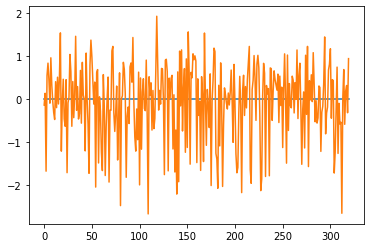

In [51]:
plt.plot(range(0, len(train_label.squeeze())), pred.squeeze(), train_label.squeeze())